<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Survey-of-text-analysis-problems" data-toc-modified-id="Survey-of-text-analysis-problems-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Survey of text analysis problems</a></span></li><li><span><a href="#Classification" data-toc-modified-id="Classification-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><span><a href="#Read-data" data-toc-modified-id="Read-data-0.2.1"><span class="toc-item-num">0.2.1&nbsp;&nbsp;</span>Read data</a></span></li><li><span><a href="#Preprocessing-and-feature-engineering" data-toc-modified-id="Preprocessing-and-feature-engineering-0.2.2"><span class="toc-item-num">0.2.2&nbsp;&nbsp;</span>Preprocessing and feature engineering</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-0.2.3"><span class="toc-item-num">0.2.3&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-0.2.4"><span class="toc-item-num">0.2.4&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-0.2.5"><span class="toc-item-num">0.2.5&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Error-analysis" data-toc-modified-id="Error-analysis-0.2.6"><span class="toc-item-num">0.2.6&nbsp;&nbsp;</span>Error analysis</a></span></li><li><span><a href="#Tuning" data-toc-modified-id="Tuning-0.2.7"><span class="toc-item-num">0.2.7&nbsp;&nbsp;</span>Tuning</a></span></li></ul></li><li><span><a href="#Common-pitfalls" data-toc-modified-id="Common-pitfalls-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Common pitfalls</a></span><ul class="toc-item"><li><span><a href="#Scalability" data-toc-modified-id="Scalability-0.3.1"><span class="toc-item-num">0.3.1&nbsp;&nbsp;</span>Scalability</a></span></li></ul></li></ul></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Clustering</a></span></li></ul></div>

<a href="https://colab.research.google.com/github/tapilab/text-analytics-tutorial/blob/master/TextAnalyticsTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analytics Tutorial <a class="tocSkip">
**Aron Culotta**  
**Associate Professor of Computer Science**  
**Illinois Institute of Technology**  
*November 13, 2019*

**Goals**
- Provide an introductory overview of text analysis techniques
- Give pointers to tools that may help with your research
- Foster collaboration across disciplines

**Agenda**

- High-level overview of some text analysis problems
- In-depth walk-through of text classication and clustering
- Open Q&A from audience

In [174]:
# imports.
import glob

from collections import Counter
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import matplotlib.pyplot as plt
import nltk
import numpy as np

import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import string
%matplotlib inline

def config_matplotlib():
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16
    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)      # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure

    sns.set(style="whitegrid")
    sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16,
                                 "xtick.labelsize": 14, "ytick.labelsize": 14})
    
def config_pandas():
    pd.set_option('display.width', 2000)
    pd.set_option('max_colwidth', 800)
    
config_matplotlib()
config_pandas()

## Survey of text analysis problems

First, let's look at an overview of a range of text analysis tasks.

Now, we'll look in more depth at two common text analysis tasks: classification and clustering.

## Classification

### Read data

In [83]:
# @title Inspect data
# data folders
!ls -d imdb/*/*
# one positive and one negative example:
print('\npositive training example')
!ls imdb/train/pos/1062_10.txt
!cat imdb/train/pos/1062_10.txt
print('\n\nnegative training example')
!ls imdb/train/neg/10277_1.txt
!cat imdb/train/neg/10277_1.txt

imdb/test/neg  imdb/test/pos  imdb/train/neg imdb/train/pos

positive training example
imdb/train/pos/1062_10.txt
I think this show is definitely the greatest show. Jessica Alba does such a great job in it. Michael Weatherly also does an awesome job, as well as the rest of the cast. The show is very intriguing and they have wonderful storylines and their stunts are amazing. It's like watching a 1-hour movie. It's definitely worth watching.

negative training example
imdb/train/neg/10277_1.txt
I feel totally ripped off. Someone needs to refund the $4.95 I spent at Blockbuster to rent this homemade mess. This is NOT a musical it is a complete waste of time and my evening. What I don't get is why did this get distributed in the first place???...somebody MUST have been doing some heavy drugs the night that deal was made. I've seen better films come out of film schools and I have been to film school so I can say that as a fact. The quality of this work is also just SO VERY bad to view...sho

In [59]:
# @title read all training files 
def read_dir(dir_name):
    data = []
    for label in ['pos', 'neg']:
        for fname in glob.glob(dir_name + '/%s/*txt' % label):
            data.append((fname, label, open(fname).read()))
    return pd.DataFrame(data, columns=['file', 'label', 'text'])

train_df = read_dir('imdb/train')
print('read %d examples with labels' % len(train_df))
display(train_df.label.value_counts())
train_df

read 400 examples with labels


neg    200
pos    200
Name: label, dtype: int64

,file,label,text
0,imdb/train/pos/10231_10.txt,pos,Here's another movie that should be loaded int...
1,imdb/train/pos/4414_9.txt,pos,Cuban Blood is one of those sleeper films that...
2,imdb/train/pos/1111_10.txt,pos,"This is not ""so bad that it is good,"" it is pu..."
3,imdb/train/pos/11900_8.txt,pos,Both visually and musically stunning. A treat ...
4,imdb/train/pos/7815_8.txt,pos,'Cry Freedom' is a movie about how far people ...
5,imdb/train/pos/8356_10.txt,pos,"Not sure if this counts as a spoiler or not, s..."
6,imdb/train/pos/8476_10.txt,pos,*** Spoilers*<br /><br />My dad had taped this...
7,imdb/train/pos/2078_9.txt,pos,This adaptation of Pearl S. Buck's film is cer...
8,imdb/train/pos/8651_9.txt,pos,"Kalifornia came out in 1993, just as 3 of the ..."
9,imdb/train/pos/11196_7.txt,pos,'One-Round' Jack Sander is called that because...


### Preprocessing and feature engineering

All machine learning models require human creativity to determine how each example should be represented. (**feature engineering**)

These decisions can often have a bigger impact on accuracy than which machine learning model you choose.

> why did this half-baked movie get distributed in the first place???...somebody MUST have been doing some heavy drugs. DON'T RENT THIS MOVIE!!!

In [92]:
# @title tokenization
"""
string -> list of strings
many decisions:
- punctuation
- contractions
- capitalization
- sentence boundaries
"""

def tokenize(text):    
    # For now, just use NLTK's default tokenizer
    return nltk.tokenize.word_tokenize(text)
    
tokenize("why did this half-baked movie get distributed in the first place???... somebody MUST have been doing some heavy drugs. DON'T RENT THIS MOVIE!!!")

['why',
 'did',
 'this',
 'half-baked',
 'movie',
 'get',
 'distributed',
 'in',
 'the',
 'first',
 'place',
 '?',
 '?',
 '?',
 '...',
 'somebody',
 'MUST',
 'have',
 'been',
 'doing',
 'some',
 'heavy',
 'drugs',
 '.',
 'DO',
 "N'T",
 'RENT',
 'THIS',
 'MOVIE',
 '!',
 '!',
 '!']

In [87]:
train_df['tokens'] = train_df.text.apply(tokenize)

In [89]:
train_df.head()

,file,label,text,tokens
0,imdb/train/pos/10231_10.txt,pos,Here's another movie that should be loaded int...,"[here, 's, another, movie, that, should, be, l..."
1,imdb/train/pos/4414_9.txt,pos,Cuban Blood is one of those sleeper films that...,"[cuban, blood, is, one, of, those, sleeper, fi..."
2,imdb/train/pos/1111_10.txt,pos,"This is not ""so bad that it is good,"" it is pu...","[this, is, not, ``, so, bad, that, it, is, goo..."
3,imdb/train/pos/11900_8.txt,pos,Both visually and musically stunning. A treat ...,"[both, visually, and, musically, stunning, ., ..."
4,imdb/train/pos/7815_8.txt,pos,'Cry Freedom' is a movie about how far people ...,"['cry, freedom, ', is, a, movie, about, how, f..."


### Feature engineering

Many choices on how to convert tokens into features.

Simple and common: **Bag of words**
- Just store how often each unique term occurs.
- Ignore order

Later on, we'll consider:
- **n-grams** (phrases of length $n$)
- lexicons (word lists)
- word embeddings

In [125]:
# @title convert tokens to bags of words
vec = CountVectorizer(tokenizer=None, analyzer=lambda i: i, min_df=1)
X_train = vec.fit_transform(train_df.tokens)
print('feature matrix has %d rows, %d columns, and %d non-zero values (%.5f%% dense)' %
      (X_train.shape[0], X_train.shape[1], X_train.nnz, X_train.nnz / (100*X_train.shape[0] * X_train.shape[1])))

feature matrix has 400 rows, 11756 columns, and 58090 non-zero values (0.00012% dense)


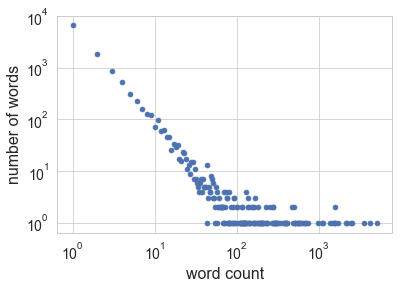

,term,counts
10447,the,5161
117,",",4281
130,.,3628
783,and,2537
404,a,2504
7320,of,2241
10593,to,2151
5654,is,1722
148,/,1590
396,>,1587


In [175]:
def plot_top_terms(X, vec):
    count_df = pd.DataFrame(zip(vec.get_feature_names(), X.sum(axis=0).A1),
                            columns=['term', 'counts']).sort_values('counts', ascending=False)
    plt.figure()
    plt.scatter(count_df.counts.value_counts().index.values, count_df.counts.value_counts().values)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('word count')
    plt.ylabel('number of words')
    plt.show()
    display(count_df)
plot_top_terms(X_train, vec)

### Training

In [171]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(X_train, train_df.label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

### Evaluation

- Precision / Recall / F1 / ROC / Confusion Matrix

### Error analysis

- Do I have enough data?
- Am I under- or over-fitting?
- Do the top features make sense? 
- Is the answer encoded in the features?

### Tuning

## Common pitfalls

### 

### Scalability

# Clustering